In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%cd drive/MyDrive/work
%ls drive/MyDrive/Colab
%pwd

%ls drive/MyDrive/work
#%ls

#%ls train_MassRegression_noTracker 


LOGS/  MODELS/  PLOTS/  torch_resnet_concat.py
drive/
MODELS/
PLOTS/
top_gun_opendata_PTscale0_ECALscale0_HCALscale1_AOD_m0o1.0_ResNet_blocks3_seedPos_MAEloss_epochs10_from0_ntrain1282048_nval512000_run0.log
top_gun_opendata_PTscale0_ECALscale0_HCALscale1_AOD_m0o85.0_ResNet_blocks3_seedPos_MAEloss_epochs10_from0_ntrain1282048_nval512000_run0.log
train_MassRegression_noTracker/


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=24f70065d4d505fe4d76e8a55457669055a3991a90280d0fffb025732e280f66
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 12.3 GB  | Proc size: 120.2 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


In [ ]:
import numpy as np
run = 0
np.random.seed(run)
import os, glob
import time
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
plt.switch_backend('agg')
#from skimage.transform import rescale
plt.rcParams["figure.figsize"] = (5,5)
from torch.utils.data import *
import pandas as pd

lr_init   = 1.e-3
resblocks = 3
epochs    = 10
load_epoch = 0
#os.environ["CUDA_VISIBLE_DEVICES"]=str(0)

run_logger = True 
#hcal_scale  = 0.2
#ecal_scale  = 0.01
#pt_scale    = 0.005
hcal_scale  = 1
ecal_scale  = 0.1
pt_scale    = 0.01
dz_scale    = 0.05
d0_scale    = 0.1
m0_scale    = 85
m1_scale    = 415
p0_scale = 400
p1_scale = 600
mass_bins = np.arange(3600,12000+700,700)/1000. # for histogram in eval()
BATCH_SIZE = 1024
#BATCH_SIZE = 64*16
n_all = BATCH_SIZE*1752 #ma>2.5 (factor 0.1)
n_val = BATCH_SIZE*500  #ma>2.5 (factor 0.1)
n_train = n_all - n_val

decay = 'top_gun_opendata'

expt_name = 'PTscale%.f_ECALscale%.f_HCALscale%.f_AOD_m0o%.1f_ResNet_blocks%d_seedPos_MAEloss_epochs%d_from%d_ntrain%d_nval%d_run%d'%(pt_scale, ecal_scale, hcal_scale, m0_scale, resblocks, epochs, load_epoch, n_train, n_val, run)
#expt_name = 'PTscale%.f_ECALscale%.f_HCALscale%.f_AOD_m0o%.1f_ResNet_blocks%d_seedPos_HUBERloss_epochs%d_from%d_ntrain%d_nval%d_run%d'%(pt_scale, ecal_scale, hcal_scale, m0_scale, resblocks, epochs, load_epoch, n_train, n_val, run)

expt_name = '%s_%s'%(decay, expt_name)
if run_logger:
    if not os.path.isdir('drive/MyDrive/work'):
        os.makedirs('drive/MyDrive/work')
    f = open('drive/MyDrive/work/%s.log'%(expt_name), 'w')
    #for d in ['MODELS', 'METRICS','PLOTS']:
    for d in ['MODELS', 'PLOTS']:
        if not os.path.isdir('drive/MyDrive/work/%s/%s'%(d, expt_name)):
            os.makedirs('drive/MyDrive/work/%s/%s'%(d, expt_name))

def logger(s):
    global f, run_logger
    print(s)
    if run_logger:
        f.write('%s\n'%str(s))

# L1 loss
def mae_loss_wgtd(pred, true, wgt=1.):
    loss = wgt*(pred-true).abs().cuda()
    return loss.mean()

# huber loss
def huber(pred, true, delta):
    loss = np.where(np.abs(true-pred) < delta , 0.5*((true-pred)**2), delta*np.abs(true - pred) - 0.5*(delta**2))
    return np.sum(loss)

# log cosh loss
def logcosh(pred, true):
    #loss = torch.mean( torch.log( torch.cosh(y - y_hat) )) 
    loss = torch.log(torch.cosh(pred - true)).cuda()
    return loss.mean()

def transform_y(y):
    return (y-m0_scale)/m1_scale

def transform_x(x):
    return (x-p0_scale)/p1_scale    


# y = (m-85)/415 so that y is mass from 0 to 1 

def inv_transform(y):
    return y*m0_scale

logger('>> Experiment: %s'%(expt_name))

>> Experiment: top_gun_opendata_PTscale0_ECALscale0_HCALscale1_AOD_m0o85.0_ResNet_blocks3_seedPos_MAEloss_epochs10_from0_ntrain1282048_nval512000_run0


In [ ]:
#!cp -r drive/MyDrive/Colab/train_MassRegression_noTracker .

#!cp -r drive/MyDrive/Colab/val_HToTauTau_m3p6To14_pT30To120_ctau0To3_eta0To1p4_noPix .

In [ ]:
ls

drive/  sample_data/


In [ ]:
class ParquetDataset(Dataset):
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        #self.cols = None # read all columns
        #self.cols = ['X_jet.list.item.list.item.list.item','am','apt','iphi','ieta'] 
        self.cols = ['X_jet.list.item.list.item.list.item','m','iphi','ieta','pt']   
        #self.label = label
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['X_jet'] = np.float32(data['X_jet'][0])
        data['X_jet'][0] = pt_scale   * data['X_jet'][0] #Track pT
        data['X_jet'][1] = dz_scale   * data['X_jet'][1] #Track dZ
        data['X_jet'][2] = d0_scale   * data['X_jet'][2] #Track d0
        data['X_jet'][3] = ecal_scale * data['X_jet'][3] #ECAL
        data['X_jet'][4] = hcal_scale * data['X_jet'][4] #HCAL 
        data['pt0'] = np.float32(data['pt']) #pt from min to max
        data['pt'] = transform_x(np.float32(data['pt'])) #pt from 0 to 1 
        data['m0'] = np.float32(data['m'])     #mass from 85 to 500
        data['m']       = transform_y(np.float32(data['m'])) #mass from 0 to 1 
        data['iphi']     = np.float32(data['iphi'])/360.
        data['ieta']     = np.float32(data['ieta'])/140.
        #data['label']    = self.label
        # Preprocessing
        #data_dict['X_jet'] = data_dict['X_jet'][:, 20:105, 20:105]
        # High Value Suppressuib
        data['X_jet'][1][data['X_jet'][1] < -1] = 0  #(20 cm)
        data['X_jet'][1][data['X_jet'][1] >  1] = 0  #(20 cm)
        data['X_jet'][2][data['X_jet'][2] < -1] = 0  #(10 cm)
        data['X_jet'][2][data['X_jet'][2] >  1] = 0  #(10 cm)
        # Zero-Suppression
        data['X_jet'][0][data['X_jet'][0] < 1.e-2] = 0. #(1 GeV)
        data['X_jet'][3][data['X_jet'][3] < 1.e-2] = 0. #(0.1 GeV)
        data['X_jet'][4][data['X_jet'][4] < 1.e-2] = 0. #(0.01 GeV)
        return dict(data)
    def __len__(self):
        return self.parquet.num_row_groups



In [ ]:

#decays_train = glob.glob('drive/MyDrive/Colab/train_HToTauTau_m2p5To14_pT30To120_ctau0To3_eta0To1p4_noPix/*.parquet*')
decays_train = glob.glob('drive/MyDrive/work/train_MassRegression_noTracker/*.parquet*')
dset_train   = ConcatDataset([ParquetDataset('%s'%d) for i,d in enumerate(decays_train)])

#decays_val = glob.glob('drive/MyDrive/Colab/val_HToTauTau_m3p6To14_pT30To120_ctau0To3_eta0To1p4_noPix/*.parquet*')
#decays_val = glob.glob('val_HToTauTau_m3p6To14_pT30To120_ctau0To3_eta0To1p4_noPix/*.parquet*')
#dset_val   = ConcatDataset([ParquetDataset('%s'%d, i) for i,d in enumerate(decays_val)])

In [ ]:
#idxs = np.random.permutation(len(dset_train))
#logger('>> N samples: %d'%(len(idxs)))
idxs_train = np.random.permutation(len(dset_train))
#idxs_val   = np.random.permutation(len(dset_val))
#idxs_train = idxs[:n_train]
#idxs_val = idxs[n_train:n_train+n_val]
logger('>> N samples: Train: %d'%(len(idxs_train)))
#np.savez('drive/MyDrive/Colab/MODELS/%s/idxs_train+val.npz'%(expt_name), idxs_train=idxs_train, idxs_val=idxs_val)
#assert len(idxs_train)+len(idxs_val) <= len(idxs), '%d vs. %d'%(len(idxs_train)+len(idxs_val), len(idxs))
# Train dataset
train_sampler = SubsetRandomSampler(idxs_train)
train_loader  = DataLoader(dataset=dset_train, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, sampler=train_sampler)
# Val dataset
#val_sampler = SubsetRandomSampler(idxs_val)
#val_loader  = DataLoader(dataset=dset_train, batch_size=BATCH_SIZE, num_workers=10, pin_memory=True, sampler=val_sampler)
#val_loader    = DataLoader(dataset=dset_val, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# Test sets
#sg_files = glob.glob('IMG/HToTauTau_m3p6To4_pT30To120_ctau0To3_eta0To1p4_unbiased_test/HToTauTau_m3p6To4_pT30To120_ctau0To3_eta0To1p4_unbiased_1*.parquet')
#dset_sg = ConcatDataset([ParquetDataset('%s'%d, i) for i,d in enumerate(sg_files)])
#sg_loader = DataLoader(dataset=dset_sg, batch_size=BATCH_SIZE, num_workers=10)
#logger('>> N test samples: sg: %d'%(len(dset_sg)))

#bg_files = glob.glob('IMG/HToTauTau_m3p6To15_pT20To200_ctau0To3_eta0To1p4_noPix_noHCAL/*.parquet.*')
#dset_bg = ConcatDataset([ParquetDataset('%s'%d, i) for i,d in enumerate(bg_files)])
#bg_loader = DataLoader(dataset=dset_bg, batch_size=BATCH_SIZE, num_workers=10)
#logger('>> N test samples: bg: %d'%(len(dset_bg)))

#drive/MyDrive/Colab

%cp drive/MyDrive/Colab/torch_resnet_concat.py .
%ls 
import torch_resnet_concat as networks
resnet = networks.ResNet(5, resblocks, [16, 32])
resnet.cuda()
optimizer = optim.Adam(resnet.parameters(), lr=lr_init)
#lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.5)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

>> N samples: Train: 149913


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


drive/  sample_data/  torch_resnet_concat.py


In [ ]:
## not now 


def do_eval(resnet, val_loader, mae_best, epoch, sample):  
    global expt_name
    loss_ = 0.
    #m_pred_, m_true_, mae_, pt_, wgts_ = [], [], [], [], []
    #m_pred_, m_true_, mae_, pt_, = [], [], [], []
    m_pred_, m_true_, mae_, mre_ = [], [], [], []
    iphi_, ieta_ = [], []
    #label_ = []
    now = time.time()
    ma_low = transform_y(3.6) # convert from GeV to network units
    for i, data in enumerate(val_loader):
        #X, m0, pt, wgts = data['Xtz_aod'].cuda(), data['m'].cuda(), data['pt'], data['w']
        #X, m0, pt = data['X_jet'].cuda(), data['am'].cuda(), data['apt']
        X, m0 = data['X_jet'].cuda(), data['am'].cuda()
        iphi, ieta = data['iphi'].cuda(), data['ieta'].cuda()
        #label = data['label'].cuda()
        #print('label ', label)
        #IP and mass selection
        #X     = X[m0[:,0]>ma_low]
        #iphi  = iphi[m0[:,0]>ma_low]
        #ieta  = ieta[m0[:,0]>ma_low]
        #label = label[m0[:,0]>ma_low]
        #m0    = m0[m0[:,0]>ma_low]
        #pt   = pt[m0[:,0]>ma_low]
        #logits = resnet(X)
        logits = resnet([X, iphi, ieta])
        loss_ += mae_loss_wgtd(logits, m0).item()
        #loss_ += logcosh(logits, m0).item()
        #criterion = torch.nn.SmoothL1Loss()
        #loss_  += criterion(logits, m0)
        # Undo preproc on mass
        logits, m0 = inv_transform(logits), inv_transform(m0)
        mre = ((logits-m0).abs()/m0)
        mae =  (logits-m0).abs()
        # Store batch metrics:
        m_pred_.append(logits.tolist())
        m_true_.append(m0.tolist())
        mae_.append(mae.tolist())
        mre_.append(mre.tolist())
        iphi_.append(iphi.tolist())
        ieta_.append(ieta.tolist())
        #label_.append(label.tolist())
        #pt_.append(pt.tolist())
        #wgts_.append(wgts.tolist())
        if i % print_step == 0:
            logger('Step : %d'%(print_step))
            
    now = time.time() - now
    #label_  = np.concatenate(label_)
    m_true_ = np.concatenate(m_true_)
    m_pred_ = np.concatenate(m_pred_)
    mae_    = np.concatenate(mae_)
    mre_    = np.concatenate(mre_)
    iphi_   = np.concatenate(iphi_)
    ieta_   = np.concatenate(ieta_)
    #pt_ = np.concatenate(pt_)[label_==tgt_label]
    #wgts_ = np.concatenate(wgts_)[label_==tgt_label]

    logger('%d: Val m_pred: %s...'%(epoch, str(np.squeeze(m_pred_[:5]))))
    logger('%d: Val m_true: %s...'%(epoch, str(np.squeeze(m_true_[:5]))))
    logger('%d: Val time:%.2fs in %d steps for N=%d'%(epoch, now, len(val_loader), len(m_true_)))
    logger('%d: Val loss:%f, mae:%f, mre:%f'%(epoch, loss_/len(val_loader), np.mean(mae_), mp.mean(mre_)))

    score_str = 'epoch%d_%s_mae%.4f'%(epoch, sample, np.mean(mae_))

    if epoch == 1 or epoch == 5 or epoch == 10 or epoch == 20:

        if 'pseudoscalar' in sample:

            # Check 2D m_true v m_pred
            logger('%d: Val m_true vs. m_pred, [3600,12000,700] MeV:'%(epoch))
            sct = np.histogram2d(np.squeeze(m_true_), np.squeeze(m_pred_), bins=mass_bins)[0]
            logger(np.uint(np.fliplr(sct).T))
            # Extended version
            plt.plot(m_true_, m_pred_, ".", color='black', alpha=0.1, label='MAE = %.3f GeV'%np.mean(mae_))
            plt.xlabel(r'$\mathrm{m_{label}}$', size=16)
            plt.ylabel(r'$\mathrm{m_{pred}}$', size=16)
            plt.plot((3.6, 14), (12, 12), color='r', linestyle='--', alpha=0.5)
            plt.plot((12, 12), (2.5, 14), color='r', linestyle='--', alpha=0.5)
            plt.plot((3.6, 14), (3.6, 3.6), color='r', linestyle='--', alpha=0.5)
            plt.plot((3.6, 14), (3.6, 14), color='r', linestyle='--', alpha=0.5)
            plt.xlim(3.6, 14)
            plt.ylim(2.5, 12)
            plt.legend(loc='upper left')
            plt.savefig('drive/MyDrive/Colab/PLOTS/%s/mtruevpred_%s.png'%(expt_name, score_str), bbox_inches='tight')
            plt.close()
            # Truncated version
            plt.plot(m_true_, m_pred_, ".", color='black', alpha=0.125, label='MAE = %.3f GeV'%np.mean(mae_))
            plt.xlabel(r'$\mathrm{m_{label}}$', size=16)
            plt.ylabel(r'$\mathrm{m_{pred}}$', size=16)
            plt.plot((3.6, 12), (3.6, 12), color='r', linestyle='--', alpha=0.5)
            plt.xlim(3.6, 12)
            plt.ylim(3.6, 12)
            plt.legend(loc='upper left')
            plt.savefig('drive/MyDrive/Colab/PLOTS/%s/mtruevpred_%s_trunc.png'%(expt_name, score_str), bbox_inches='tight')
            plt.close()

        # Check 1D m_pred
        hst = np.histogram(np.squeeze(m_pred_), bins=mass_bins)[0]
        logger('%d: Val m_pred, [3600,12000,700] MeV: %s'%(epoch, str(np.uint(hst))))
        mlow = hst[0]
        mrms = np.std(hst)
        logger('%d: Val m_pred, [3600,12000,700] MeV: low:%d, rms: %f'%(epoch, mlow, mrms))
        norm = 1.*len(m_pred_)/len(m0)
        plt.hist(m_true_, range=(2.5,14), bins=20, histtype='step', label=r'$\mathrm{m_{true}}$', linestyle='--', color='grey', alpha=0.6)
        plt.hist(m_pred_, range=(2.5,14), bins=20, histtype='step', label=r'$\mathrm{m_{pred}}$', linestyle='--', color='C0', alpha=0.6)
        #plt.hist((m_true_ if 'pseudoscalar' in sample else np.zeros_like(m_true_)),\
        #        #range=(3.6,15), bins=20, histtype='step', label=r'$\mathrm{m_{true,w}}$', color='grey', weights=wgts_*norm)
        #        range=(3.6,17), bins=20, histtype='step', label=r'$\mathrm{m_{true,w}}$', color='grey', weights=norm)
        #plt.hist(m_pred_, range=(-1,17), bins=20, histtype='step', label=r'$\mathrm{m_{pred,w}}$', color='C0', weights=wgts_*norm)
        #plt.hist(m_pred_, range=(3.6,17), bins=20, histtype='step', label=r'$\mathrm{m_{pred,w}}$', color='C0', weights=norm)
        plt.xlim(2.5,14)
        plt.xlabel(r'$\mathrm{m}$', size=16)
        if 'pseudoscalar' in sample:
            plt.legend(loc='lower center')
        else:
            plt.legend(loc='upper right')
        plt.show()
        plt.savefig('PLOTS/%s/mpred_%s.png'%(expt_name, score_str), bbox_inches='tight')
        plt.close()

    if run_logger:
        if 'pseudoscalar' in sample and 'val' in sample:
            epoch_str = 'epoch%d_%s'%(epoch, sample)
            filename  = 'drive/MyDrive/Colab/MODELS/%s/model_%s.pkl'%(expt_name, score_str.replace('_val_pseudoscalar',''))
            loss_value = loss_/len(val_loader)
            model_dict = {'model_state_dict': resnet.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'epoch' : epoch, 'loss': loss_value}
            torch.save(model_dict, filename)

    return np.mean(mae_)

In [ ]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [ ]:
batch=next(iter(train_loader))
print("Image size = ", batch["X_jet"].size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Image size =  torch.Size([1024, 8, 125, 125])


In [ ]:
print("mass size = ",batch["m"].size())
print(batch["pt0"].size())

mass size =  torch.Size([1024, 1])
torch.Size([1024, 1])


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

## Mass 

In [ ]:
channel_6=pd.Series(batch["m0"].flatten())
channel_6.describe()

count    1024.000000
mean      292.127808
std       123.197037
min        85.815590
25%       179.636326
50%       292.095215
75%       403.530891
max       499.905823
dtype: float64

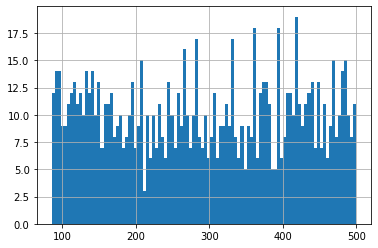

In [ ]:
channel_6.hist(bins=100)

In [ ]:
channel_5=pd.Series(batch["m"].flatten())
channel_5.describe()

## pandas flatten ->Return a copy of the array collapsed into one dimension.

count    1024.000000
mean        0.499104
std         0.296860
min         0.001965
25%         0.228039
50%         0.499025
75%         0.767544
max         0.999773
dtype: float64

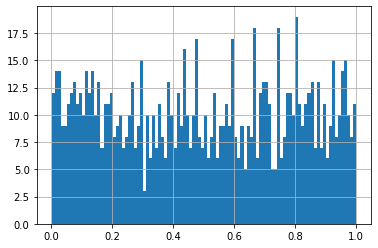

In [ ]:
#channel_5.hist()
channel_5.hist(bins=100)

#mass ranges from 85 to 500 

# y = (m-85)/415 so that y is mass from 0 to 1 

# pT

In [ ]:
channel_7=pd.Series(batch["pt0"].flatten())
channel_7.describe()

count    1024.000000
mean      709.564209
std       168.492569
min       403.140411
25%       569.165176
50%       722.486420
75%       852.052139
max       999.155212
dtype: float64

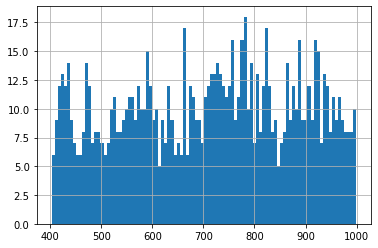

In [ ]:
channel_7.hist(bins=100)

In [ ]:
channel_8=pd.Series(batch["pt"].flatten())
channel_8.describe()

count    1024.000000
mean        0.515940
std         0.280821
min         0.005234
25%         0.281942
50%         0.537477
75%         0.753420
max         0.998592
dtype: float64

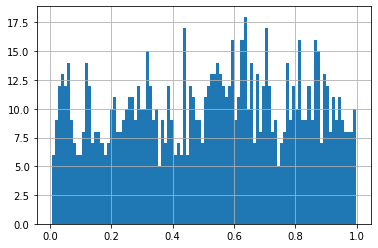

In [ ]:
channel_8.hist(bins=100)

## Track pT

In [ ]:
#%matplotlib inline
#import matplotlib.pyplot as plt
#import pandas as pd
channel_1=pd.Series(batch["X_jet"][:,0].flatten())
channel_1[(channel_1>0)].describe()

count    27807.000000
mean         0.162270
std          1.106397
min          0.010001
25%          0.026974
50%          0.057733
75%          0.143358
max        121.294907
dtype: float64

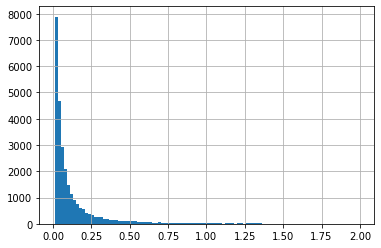

In [ ]:
#(channel_1[(channel_1>0)]).hist()
(channel_1[(channel_1>0) & (channel_1<2)]).hist(bins=100)

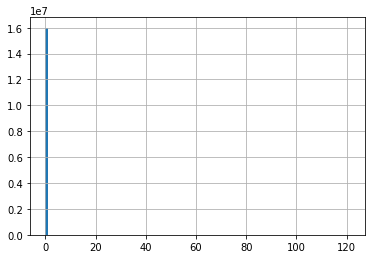

In [ ]:
channel_1.hist(bins=100)

## Track dZ

In [ ]:
channel_2=pd.Series(batch["X_jet"][:,1].flatten())
channel_2[(channel_2!=0)].describe()

count    27168.000000
mean        -0.000120
std          0.195739
min         -0.999835
25%         -0.042567
50%          0.000165
75%          0.042170
max          0.998489
dtype: float64

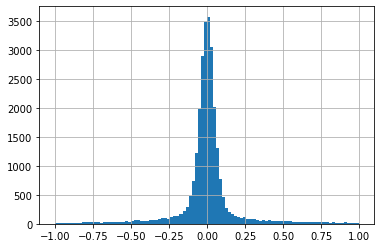

In [ ]:
(channel_2[(channel_2!=0)]).hist(bins=100)
#(channel_2[(channel_2>0) & (channel_2<50)]).hist()

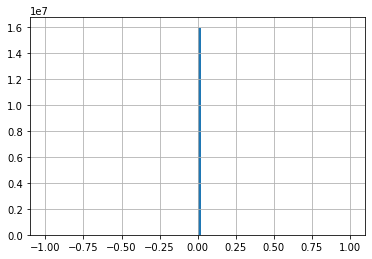

In [ ]:
channel_2.hist(bins=100)

## Track d0

In [ ]:
channel_3=pd.Series(batch["X_jet"][:,2].flatten())
channel_3[(channel_3!=0) ].describe()

count    22864.000000
mean         0.002199
std          0.238511
min         -0.999858
25%         -0.070549
50%          0.002220
75%          0.073540
max          0.999901
dtype: float64

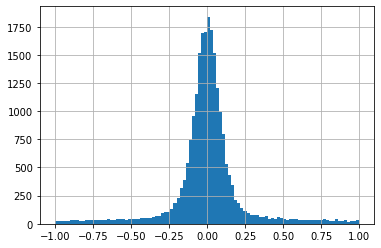

In [ ]:
#channel_3.hist()
(channel_3[(channel_3!=0)] ).hist(bins=100)

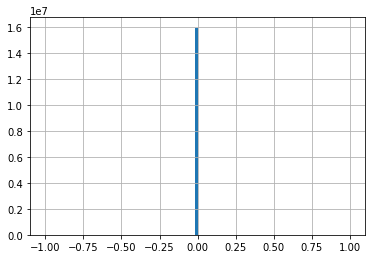

In [ ]:
channel_3.hist(bins=100)

## ECAL

In [ ]:
channel_4=pd.Series(batch["X_jet"][:,3].flatten())
channel_4[(channel_4>0)].describe()

count    277372.000000
mean          0.141358
std           0.678102
min           0.010000
25%           0.014596
50%           0.025862
75%           0.068984
max          61.189526
dtype: float64

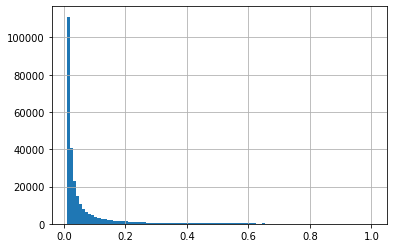

In [ ]:
(channel_4[(channel_4>0) & (channel_4<1)]).hist(bins=100)

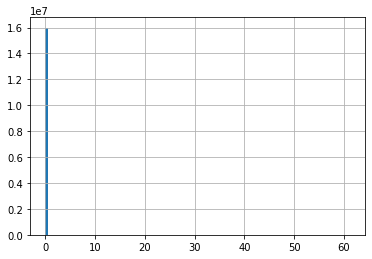

In [ ]:
channel_4.hist(bins=100)

## HCAL

In [ ]:
channel_5=pd.Series(batch["X_jet"][:,4].flatten())
channel_5[(channel_5>0)].describe()

count    719425.000000
mean          0.485996
std           1.189538
min           0.010013
25%           0.068336
50%           0.130717
75%           0.338480
max          21.201221
dtype: float64

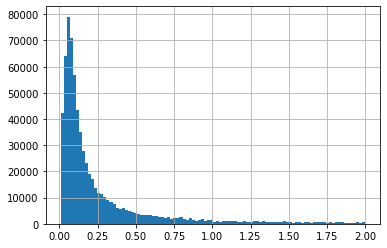

In [ ]:
(channel_5[(channel_5>0) & (channel_5<2)]).hist(bins=100)

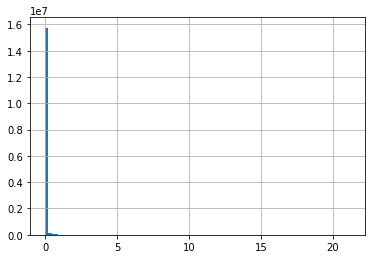

In [ ]:
channel_5.hist(bins=100)

In [ ]:
# MAIN #

if load_epoch != 0:
    epoch_string = 'drive/MyDrive/Colab/MODELS/HToTauTau_m2p0To14_pT30To120_ctau0To3_eta0To1p4_noPix_PTscale0_ECALscale0_HCALscale0_AOD_m0o14.0_ResNet_blocks3_seedPos_MAEloss_epochs10_from0_ntrain342272_nval128000_run0/model_epoch%d'%(load_epoch)
    for model_name in glob.glob('%s*pkl'%(epoch_string)):
        print(model_name)
        #model_name = 'drive/MyDrive/Colab/MODELS/%s/model_epoch%d.pkl'%(model_directory, load_epoch)
        logger('Loading weights from %s'%model_name)
        checkpoint = torch.load(model_name)
        resnet.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = load_epoch
        #resnet.load_state_dict(checkpoint['model_state_dict'])
        #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #epoch = checkpoint['epoch']
        #loss = checkpoint['loss']
        #resnet.load_weights(model_name)

print_step = 100
#print_step = 10000
mae_best = 1.
logger(">> Training <<<<<<<<")
for e in range(epochs):

    epoch = e+1+load_epoch
    epoch_wgt = 0.
    n_trained = 0
    logger('>> Epoch %d <<<<<<<<'%(epoch))

    # Run training
    #lr_scheduler.step()
    resnet.train()
    now = time.time()
    for i, data in enumerate(train_loader):
        #X, m0, wgts = data['Xtz_aod'].cuda(), data['m'].cuda(), data['w'].cuda()
        X, m0 = data['X_jet'].cuda(), data['m'].cuda()
        iphi, ieta = data['iphi'].cuda(), data['ieta'].cuda()
        optimizer.zero_grad()
        #logits = resnet(X)
        logits = resnet([X, iphi, ieta])
        #loss     = mae_loss_wgtd(logits, m0, wgt=1)
        loss     = mae_loss_wgtd(logits, m0)
        #loss     = logcosh(logits, m0)
        #criterion = torch.nn.SmoothL1Loss()
        #loss      = criterion(logits, m0)
        #break
        loss.backward()
        optimizer.step()
        epoch_wgt += len(m0) 
        #epoch_wgt += wgts.sum()
        n_trained += 1
        if i % print_step == 0:
            logits, m0 = inv_transform(logits), inv_transform(m0)
            mre = ((logits-m0).abs()/m0).mean()
            mae =  (logits-m0).abs().mean()
            logger('%d: (%d/%d) m_pred: %s...'%(epoch, i, len(train_loader), str(np.squeeze(logits.tolist()[:5]))))
            logger('%d: (%d/%d) m_true: %s...'%(epoch, i, len(train_loader), str(np.squeeze(m0.tolist()[:5]))))
            logger('%d: (%d/%d) Train loss:%f, mae:%f, mre:%f'%(epoch, i, len(train_loader), loss.item(), mae.item(), mre.item() ))

    now = time.time() - now
    logits, m0 = inv_transform(logits), inv_transform(m0)
    mae =  (logits-m0).abs().mean()
    mre = ((logits-m0).abs()/m0).mean()
    logger('%d: Train time:%.2fs in %d steps for N:%d, wgt: %.f'%(epoch, now, len(train_loader), n_trained, epoch_wgt))
    logger('%d: Train loss:%f, mae:%f, mre:%f'%(epoch, loss.item(), mae.item(), mre.item() ))

    # Run Validation
    resnet.eval()
    _ = do_eval(resnet, val_loader, mae_best, epoch, 'val_pseudoscalar')
    #_ = do_eval(resnet, val_loader, mae_best, epoch, 'val_tau', 0)

    #_ = do_eval(resnet, sg_loader, mae_best, epoch, 'test_pseudoscalar_M3.6To4', 1)
    #_ = do_eval(resnet, bg_loader, mae_best, epoch, 'test_pseudoscalar_M3.6To15', 1)

if run_logger:
    f.close()


>> Training <<<<<<<<
>> Epoch 1 <<<<<<<<


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyError: ignored

In [ ]:
ls drive/MyDrive/Colab/MODELS/HToTauTau_m2p0To14_pT30To120_ctau0To3_eta0To1p4_noPix_PTscale0_ECALscale0_HCALscale0_AOD_m0o14.0_ResNet_blocks3_seedPos_MAEloss_epochs10_from0_ntrain342272_nval128000_run0/
